# 가스공급량 수요예측 모델개발 🏭

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['font.family'] = 'NanumBarunGothic'
%config inlinebackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_row', 526)
pd.set_option('display.max_columns', 100)

## Data Load

In [ ]:
path = '/content/drive/MyDrive/gas_supply/'
train = pd.read_csv(path + 'train_clean.csv')
test = pd.read_csv(path + 'test_clean.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

train['date'] = pd.to_datetime(train.date)
test['date'] = pd.to_datetime(test.date)

## feature

In [ ]:
def date_feature(df):
    df['date'] = pd.to_datetime(df['date'])
    df['week'] = df['date'].dt.week
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour

    df['weekday'] = df['date'].dt.weekday
    # df['weekofyear'] = df['date'].dt.weekofyear
    df['days_in_month'] = df['date'].dt.days_in_month
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['is_leap_year'] = df['date'].dt.is_leap_year
    df['is_month_start'] = df['date'].dt.is_month_start
    df['is_month_end'] = df['date'].dt.is_month_end
    df['is_quarter_start'] = df['date'].dt.is_quarter_start
    df['is_quarter_end'] = df['date'].dt.is_quarter_end
    df['is_year_start'] = df['date'].dt.is_year_start
    df['is_year_end'] = df['date'].dt.is_year_end

    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()
    df['year'] = le.fit_transform(df['year'])
    df['weekday'] = le.fit_transform(df['weekday'])
    # df['weekofyear'] = le.fit_transform(df['weekofyear'])
    df['days_in_month'] = le.fit_transform(df['days_in_month'])
    df['quarter'] = le.fit_transform(df['quarter'])
    df['dayofyear'] = le.fit_transform(df['dayofyear'])
    df['is_leap_year'] = le.fit_transform(df['is_leap_year'])
    df['is_month_start'] = le.fit_transform(df['is_month_start'])
    df['is_month_end'] = le.fit_transform(df['is_month_end'])
    df['is_quarter_start'] = le.fit_transform(df['is_quarter_start'])
    df['is_quarter_end'] = le.fit_transform(df['is_quarter_end'])
    df['is_year_start'] = le.fit_transform(df['is_year_start'])
    df['is_year_end'] = le.fit_transform(df['is_year_end'])


    df['sin_time'] = np.sin(2*np.pi*df['hour']/24)
    df['cos_time'] = np.cos(2*np.pi*df['hour']/24)

    return df

In [ ]:
df = pd.concat([train, test])
df = date_feature(df)
train = df[:368088]
test = df[368088:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# train = date_feature(train)
# test = date_feature(test)

## Outlier

In [ ]:
for i in range(len(train['num'].unique())):
    globals()['outlier_{}'.format(i+1)] = train[train['num'] == i+1]
    for j in range(1,13):
        globals()['outlier_{}_{}'.format(i+1, j)] = locals()['outlier_{}'.format(i+1)][locals()['outlier_{}'.format(i+1)]['month'] == j]
        locals()['outlier_{}_{}'.format(i+1, j)].reset_index(drop=True, inplace=True)

In [ ]:
def outlier_iqr(data, column, cut_value): 

    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * cut_value
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]

    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.')

In [ ]:
outlier_idx = set()
cut_value_value = 1.75
for i in range(len(train['num'].unique())):
    for j in range(1,13):
        print(f'num={i+1}, month={j}')
        outlier_iqr(locals()['outlier_{}_{}'.format(i+1,j)],'supply', cut_value_value)
        for k in train[train.month == j][train.num == i+1].supply[train[train.month == j][train.num == i+1].supply > upper].index.values:
            outlier_idx.add(k)
        for k in train[train.month == j][train.num == i+1].supply[train[train.month == j][train.num == i+1].supply < lower].index.values:
            outlier_idx.add(k)

num=1, month=1
IQR은 748.4520000000002 이다.
lower bound 값은 591.2250959999994 이다.
upper bound 값은 3962.252904000001 이다.
총 이상치 개수는 4 이다.
num=1, month=2
IQR은 664.7639999999999 이다.
lower bound 값은 554.6904720000005 이다.
upper bound 값은 3548.787528 이다.
총 이상치 개수는 15 이다.
num=1, month=3
IQR은 597.3259999999998 이다.
lower bound 값은 105.48984800000039 이다.
upper bound 값은 2795.8461519999996 이다.
총 이상치 개수는 11 이다.
num=1, month=4
IQR은 359.4040000000001 이다.
lower bound 값은 113.05919199999983 이다.
upper bound 값은 1731.8148080000003 이다.
총 이상치 개수는 60 이다.
num=1, month=5
IQR은 280.0540000000001 이다.
lower bound 값은 29.242391999999768 이다.
upper bound 값은 1290.6056080000003 이다.
총 이상치 개수는 2 이다.
num=1, month=6
IQR은 376.4159999999998 이다.
lower bound 값은 -254.54583199999968 이다.
upper bound 값은 1440.8318319999996 이다.
총 이상치 개수는 0 이다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_l

num=1, month=7
IQR은 450.6060000000001 이다.
lower bound 값은 -404.88471200000015 이다.
upper bound 값은 1624.6447120000003 이다.
총 이상치 개수는 0 이다.
num=1, month=8
IQR은 443.14799999999985 이다.
lower bound 값은 -412.51429599999966 이다.
upper bound 값은 1583.4242959999997 이다.
총 이상치 개수는 0 이다.
num=1, month=9
IQR은 354.7965 이다.
lower bound 값은 -241.68421800000004 이다.
upper bound 값은 1356.319218 이다.
총 이상치 개수는 0 이다.
num=1, month=10
IQR은 301.6757500000001 이다.
lower bound 값은 69.3310859999998 이다.
upper bound 값은 1428.0786640000001 이다.
총 이상치 개수는 72 이다.
num=1, month=11
IQR은 602.4937500000003 이다.
lower bound 값은 13.88244999999938 이다.
upper bound 값은 2727.5143000000007 이다.
총 이상치 개수는 7 이다.
num=1, month=12
IQR은 705.1035000000002 이다.
lower bound 값은 508.35216799999966 이다.
upper bound 값은 3684.1383320000004 이다.
총 이상치 개수는 1 이다.
num=2, month=1
IQR은 672.6600000000001 이다.
lower bound 값은 454.4126799999997 이다.
upper bound 값은 3484.07332 이다.
총 이상치 개수는 4 이다.
num=2, month=2
IQR은 606.9165000000003 이다.
lower bound 값은 412.3152919999993 이다.
upp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-pack

num=2, month=3
IQR은 546.3999999999999 이다.
lower bound 값은 -6.93979999999965 이다.
upper bound 값은 2454.0458 이다.
총 이상치 개수는 9 이다.
num=2, month=4
IQR은 331.29999999999995 이다.
lower bound 값은 1.6154000000000224 이다.
upper bound 값은 1493.7905999999998 이다.
총 이상치 개수는 57 이다.
num=2, month=5
IQR은 214.61625000000015 이다.
lower bound 값은 15.145329999999774 이다.
upper bound 값은 981.7769200000005 이다.
총 이상치 개수는 4 이다.
num=2, month=6
IQR은 277.96000000000004 이다.
lower bound 값은 -214.4129200000001 이다.
upper bound 값은 1037.51892 이다.
총 이상치 개수는 0 이다.
num=2, month=7
IQR은 324.4555000000002 이다.
lower bound 값은 -315.5685360000004 이다.
upper bound 값은 1145.7790360000006 이다.
총 이상치 개수는 9 이다.
num=2, month=8
IQR은 338.5755000000002 이다.
lower bound 값은 -364.3067760000004 이다.
upper bound 값은 1160.6372760000006 이다.
총 이상치 개수는 0 이다.
num=2, month=9
IQR은 274.1974999999999 이다.
lower bound 값은 -220.7807699999998 이다.
upper bound 값은 1014.2047699999996 이다.
총 이상치 개수는 0 이다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/pyt

num=2, month=10
IQR은 258.08 이다.
lower bound 값은 -1.3031599999999912 이다.
upper bound 값은 1161.08916 이다.
총 이상치 개수는 83 이다.
num=2, month=11
IQR은 575.0849999999999 이다.
lower bound 값은 -151.67791999999963 이다.
upper bound 값은 2438.50492 이다.
총 이상치 개수는 4 이다.
num=2, month=12
IQR은 624.4705000000006 이다.
lower bound 값은 426.2409339999988 이다.
upper bound 값은 3238.8560660000016 이다.
총 이상치 개수는 0 이다.
num=3, month=1
IQR은 45.43025000000003 이다.
lower bound 값은 114.58420199999995 이다.
upper bound 값은 319.2020480000001 이다.
총 이상치 개수는 39 이다.
num=3, month=2
IQR은 44.95600000000002 이다.
lower bound 값은 99.45308799999992 이다.
upper bound 값은 301.934912 이다.
총 이상치 개수는 34 이다.
num=3, month=3
IQR은 42.400000000000006 이다.
lower bound 값은 60.693199999999976 이다.
upper bound 값은 251.6628 이다.
총 이상치 개수는 1 이다.
num=3, month=4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-pack

IQR은 42.90599999999999 이다.
lower bound 값은 29.56268800000001 이다.
upper bound 값은 222.811312 이다.
총 이상치 개수는 226 이다.
num=3, month=5
IQR은 46.54100000000001 이다.
lower bound 값은 -7.502832000000026 이다.
upper bound 값은 202.11783200000002 이다.
총 이상치 개수는 0 이다.
num=3, month=6
IQR은 28.799999999999997 이다.
lower bound 값은 22.12040000000001 이다.
upper bound 값은 151.8356 이다.
총 이상치 개수는 511 이다.
num=3, month=7
IQR은 32.8 이다.
lower bound 값은 19.912400000000005 이다.
upper bound 값은 167.6436 이다.
총 이상치 개수는 544 이다.
num=3, month=8
IQR은 22.39999999999999 이다.
lower bound 값은 40.53320000000002 이다.
upper bound 값은 141.4228 이다.
총 이상치 개수는 508 이다.
num=3, month=9
IQR은 28.562250000000006 이다.
lower bound 값은 37.72643799999997 이다.
upper bound 값은 166.370812 이다.
총 이상치 개수는 39 이다.
num=3, month=10
IQR은 24.50399999999999 이다.
lower bound 값은 52.84699200000002 이다.
upper bound 값은 163.21300799999997 이다.
총 이상치 개수는 25 이다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-pack

num=3, month=11
IQR은 43.75125000000001 이다.
lower bound 값은 39.458809999999986 이다.
upper bound 값은 236.51444000000004 이다.
총 이상치 개수는 18 이다.
num=3, month=12
IQR은 52.72649999999999 이다.
lower bound 값은 76.27467200000002 이다.
upper bound 값은 313.754828 이다.
총 이상치 개수는 46 이다.
num=4, month=1
IQR은 432.0387499999997 이다.
lower bound 값은 348.1763600000005 이다.
upper bound 값은 2294.0788899999993 이다.
총 이상치 개수는 5 이다.
num=4, month=2
IQR은 387.3082500000004 이다.
lower bound 값은 325.30469599999935 이다.
upper bound 값은 2069.741054000001 이다.
총 이상치 개수는 15 이다.
num=4, month=3
IQR은 347.904 이다.
lower bound 값은 79.57294200000001 이다.
upper bound 값은 1646.532558 이다.
총 이상치 개수는 2 이다.
num=4, month=4
IQR은 233.17399999999992 이다.
lower bound 값은 34.924152000000106 이다.
upper bound 값은 1085.1398479999998 이다.
총 이상치 개수는 39 이다.
num=4, month=5
IQR은 163.33075000000002 이다.
lower bound 값은 5.680525999999986 이다.
upper bound 값은 741.322224 이다.
총 이상치 개수는 5 이다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_l

num=4, month=6
IQR은 174.72299999999998 이다.
lower bound 값은 -98.03019599999996 이다.
upper bound 값은 688.922196 이다.
총 이상치 개수는 0 이다.
num=4, month=7
IQR은 179.12600000000003 이다.
lower bound 값은 -125.85575200000005 이다.
upper bound 값은 680.927752 이다.
총 이상치 개수는 0 이다.
num=4, month=8
IQR은 172.27925000000002 이다.
lower bound 값은 -134.23024600000005 이다.
upper bound 값은 641.715496 이다.
총 이상치 개수는 0 이다.
num=4, month=9
IQR은 172.27774999999997 이다.
lower bound 값은 -105.41261799999995 이다.
upper bound 값은 670.5263679999999 이다.
총 이상치 개수는 0 이다.
num=4, month=10
IQR은 199.75924999999995 이다.
lower bound 값은 -19.42320599999988 이다.
upper bound 값은 880.2924559999999 이다.
총 이상치 개수는 56 이다.
num=4, month=11
IQR은 367.4077500000001 이다.
lower bound 값은 -8.405378000000155 이다.
upper bound 값은 1646.3991280000002 이다.
총 이상치 개수는 8 이다.
num=4, month=12
IQR은 402.75750000000016 이다.
lower bound 값은 335.7836099999996 이다.
upper bound 값은 2149.8033900000005 이다.
총 이상치 개수는 0 이다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/pyt

num=5, month=1
IQR은 943.0820000000008 이다.
lower bound 값은 721.6213359999986 이다.
upper bound 값은 4969.262664000002 이다.
총 이상치 개수는 17 이다.
num=5, month=2
IQR은 823.1957499999994 이다.
lower bound 값은 731.4762960000012 이다.
upper bound 값은 4439.149953999999 이다.
총 이상치 개수는 22 이다.
num=5, month=3
IQR은 742.7182500000004 이다.
lower bound 값은 124.91262599999959 이다.
upper bound 값은 3470.115624000001 이다.
총 이상치 개수는 5 이다.
num=5, month=4
IQR은 468.99800000000005 이다.
lower bound 값은 76.77850399999988 이다.
upper bound 값은 2189.145496 이다.
총 이상치 개수는 53 이다.
num=5, month=5
IQR은 259.7354999999999 이다.
lower bound 값은 178.87040400000012 이다.
upper bound 값은 1348.7190959999996 이다.
총 이상치 개수는 22 이다.
num=5, month=6
IQR은 314.70599999999996 이다.
lower bound 값은 -76.5979119999999 이다.
upper bound 값은 1340.837912 이다.
총 이상치 개수는 0 이다.
num=5, month=7
IQR은 341.64400000000006 이다.
lower bound 값은 -164.08728800000011 이다.
upper bound 값은 1374.6772880000003 이다.
총 이상치 개수는 0 이다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_l

num=5, month=8
IQR은 339.7799999999999 이다.
lower bound 값은 -198.35155999999978 이다.
upper bound 값은 1332.0175599999998 이다.
총 이상치 개수는 0 이다.
num=5, month=9
IQR은 308.8725 이다.
lower bound 값은 -100.16612000000003 이다.
upper bound 값은 1290.9956200000001 이다.
총 이상치 개수는 0 이다.
num=5, month=10
IQR은 351.39250000000004 이다.
lower bound 값은 48.99333999999999 이다.
upper bound 값은 1631.66516 이다.
총 이상치 개수는 71 이다.
num=5, month=11
IQR은 792.1472499999998 이다.
lower bound 값은 -135.6357319999995 이다.
upper bound 값은 3432.1954819999996 이다.
총 이상치 개수는 5 이다.
num=5, month=12
IQR은 891.8655000000008 이다.
lower bound 값은 628.6863939999982 이다.
upper bound 값은 4645.648606000002 이다.
총 이상치 개수는 0 이다.
num=6, month=1
IQR은 1111.6239999999998 이다.
lower bound 값은 1055.6037520000002 이다.
upper bound 값은 6062.358248 이다.
총 이상치 개수는 23 이다.
num=6, month=2
IQR은 1001.5879999999997 이다.
lower bound 값은 1000.1788240000008 이다.
upper bound 값은 5511.331176 이다.
총 이상치 개수는 24 이다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-pack

num=6, month=3
IQR은 849.9520000000002 이다.
lower bound 값은 629.2430959999995 이다.
upper bound 값은 4457.426904000001 이다.
총 이상치 개수는 3 이다.
num=6, month=4
IQR은 614.64375 이다.
lower bound 값은 473.14115000000015 이다.
upper bound 값은 3241.4966 이다.
총 이상치 개수는 11 이다.
num=6, month=5
IQR은 521.2099999999998 이다.
lower bound 값은 214.2250800000005 이다.
upper bound 값은 2561.75492 이다.
총 이상치 개수는 0 이다.
num=6, month=6
IQR은 589.4219999999999 이다.
lower bound 값은 -81.96234399999992 이다.
upper bound 값은 2572.794344 이다.
총 이상치 개수는 0 이다.
num=6, month=7
IQR은 594.34025 이다.
lower bound 값은 -123.047368 이다.
upper bound 값은 2553.861118 이다.
총 이상치 개수는 0 이다.
num=6, month=8
IQR은 561.0395000000005 이다.
lower bound 값은 -124.8189540000011 이다.
upper bound 값은 2402.1029540000013 이다.
총 이상치 개수는 0 이다.
num=6, month=9
IQR은 612.7422499999999 이다.
lower bound 값은 -156.80367199999966 이다.
upper bound 값은 2602.9874219999997 이다.
총 이상치 개수는 0 이다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_l

num=6, month=10
IQR은 607.5455000000002 이다.
lower bound 값은 179.8512839999994 이다.
upper bound 값은 2916.2362160000002 이다.
총 이상치 개수는 26 이다.
num=6, month=11
IQR은 971.6964999999998 이다.
lower bound 값은 225.85673200000042 이다.
upper bound 값은 4602.377767999999 이다.
총 이상치 개수는 10 이다.
num=6, month=12
IQR은 1036.5539999999996 이다.
lower bound 값은 1053.6763920000012 이다.
upper bound 값은 5722.315607999999 이다.
총 이상치 개수는 2 이다.
num=7, month=1
IQR은 171.43750000000006 이다.
lower bound 값은 120.40749999999991 이다.
upper bound 값은 892.5620000000001 이다.
총 이상치 개수는 7 이다.
num=7, month=2
IQR은 155.724 이다.
lower bound 값은 111.41955200000001 이다.
upper bound 값은 812.800448 이다.
총 이상치 개수는 9 이다.
num=7, month=3
IQR은 138.38400000000007 이다.
lower bound 값은 16.511231999999865 이다.
upper bound 값은 639.7927680000001 이다.
총 이상치 개수는 1 이다.
num=7, month=4
IQR은 94.43 이다.
lower bound 값은 -2.2033600000000035 이다.
upper bound 값은 423.10936000000004 이다.
총 이상치 개수는 39 이다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-pack

num=7, month=5
IQR은 58.995999999999995 이다.
lower bound 값은 5.113008000000008 이다.
upper bound 값은 270.830992 이다.
총 이상치 개수는 18 이다.
num=7, month=6
IQR은 68.0605 이다.
lower bound 값은 -43.26649600000002 이다.
upper bound 값은 263.27799600000003 이다.
총 이상치 개수는 1 이다.
num=7, month=7
IQR은 75.73200000000001 이다.
lower bound 값은 -65.06646400000001 이다.
upper bound 값은 276.03046400000005 이다.
총 이상치 개수는 0 이다.
num=7, month=8
IQR은 73.8905 이다.
lower bound 값은 -70.33265599999999 이다.
upper bound 값은 262.470156 이다.
총 이상치 개수는 2 이다.
num=7, month=9
IQR은 67.12124999999999 이다.
lower bound 값은 -47.960429999999974 이다.
upper bound 값은 254.35368 이다.
총 이상치 개수는 0 이다.
num=7, month=10
IQR은 69.334 이다.
lower bound 값은 -6.079167999999996 이다.
upper bound 값은 306.201168 이다.
총 이상치 개수는 62 이다.
num=7, month=11
IQR은 138.40649999999994 이다.
lower bound 값은 -23.12218799999991 이다.
upper bound 값은 600.2606879999998 이다.
총 이상치 개수는 9 이다.
num=7, month=12
IQR은 160.7337500000001 이다.
lower bound 값은 99.32246999999984 이다.
upper bound 값은 823.2672800000003 이다.
총 이상

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-pack

### outlier plot

In [ ]:
for i in range(len(train['num'].unique())):
    globals()['quarter_{}'.format(i+1)] = train[train['num'] == i+1]
    for j in range(0,4):
        globals()['quarter_{}_{}'.format(i+1, j)] = locals()['quarter_{}'.format(i+1)][locals()['outlier_{}'.format(i+1)]['quarter'] == j]
        locals()['quarter_{}_{}'.format(i+1, j)].reset_index(drop=True, inplace=True)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


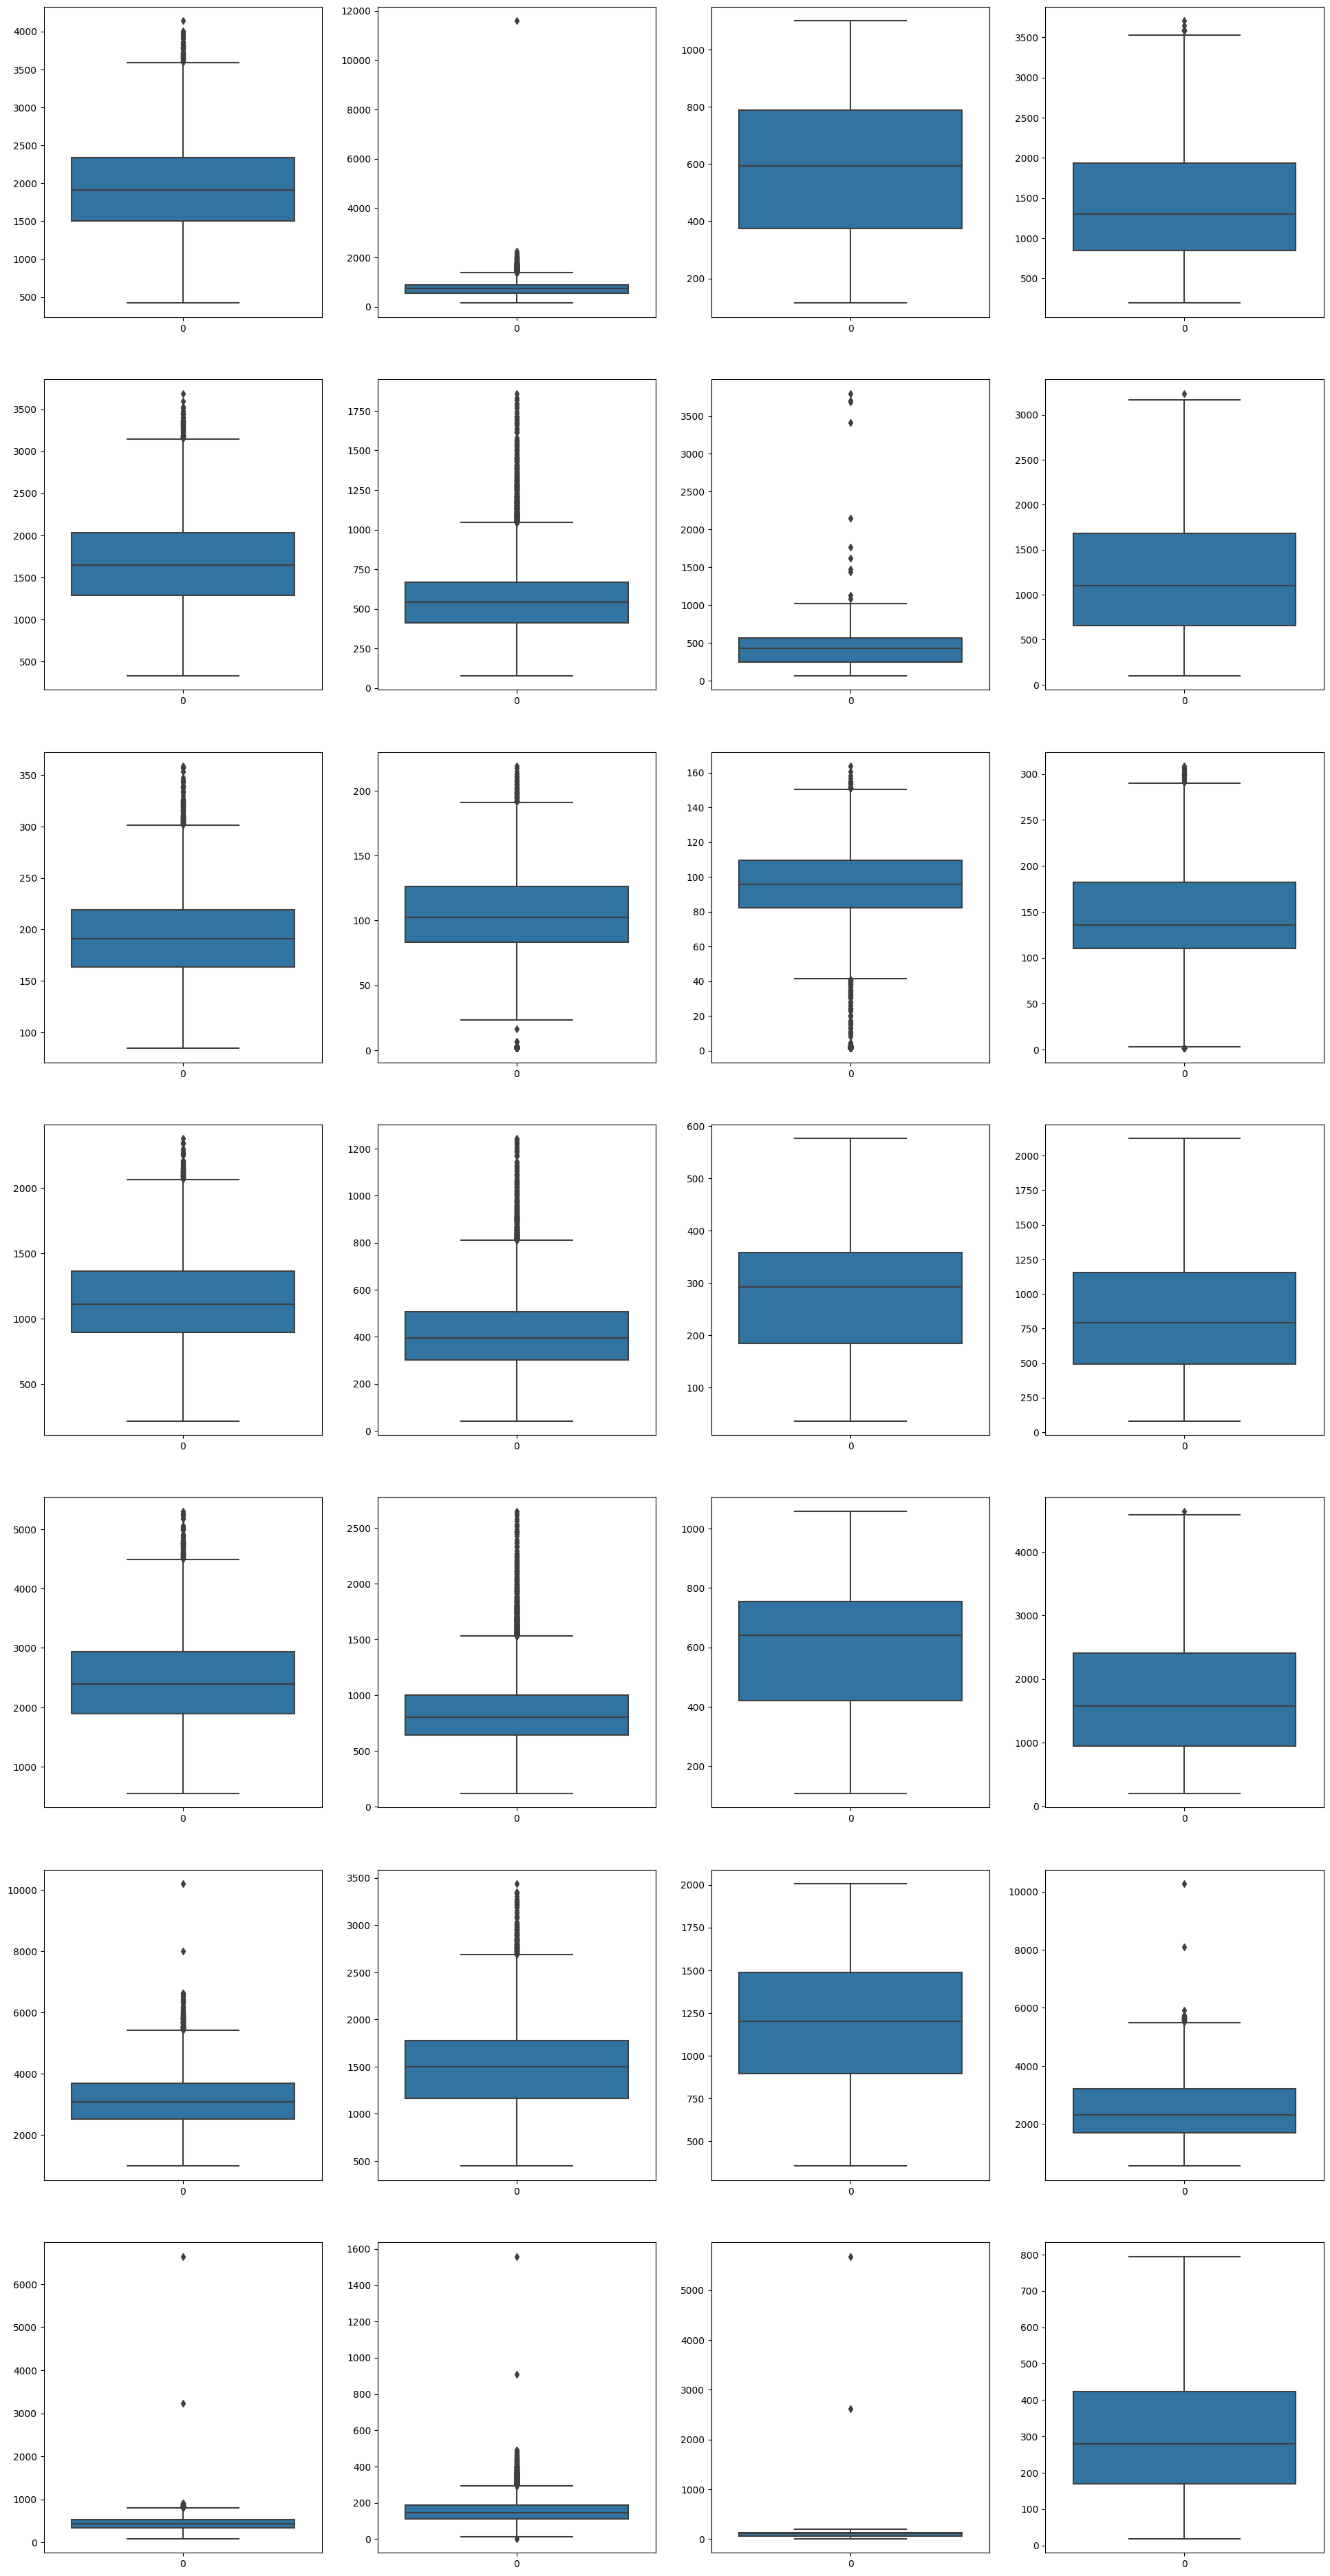

In [ ]:
plt.figure(figsize=(24,49))
count = 1
for i in range(len(train['num'].unique())):
    for j in range(0,4):
        plt.subplot(7,4,count)
        sns.boxplot(data=locals()['quarter_{}_{}'.format(i+1, j)]['supply'])
        count+=1
plt.show()

In [ ]:
outlier_idx = set()

In [ ]:
# for i in train[train.month == 1].supply[train[train.month == 1].supply >= 10000].index.values:
#     outlier_idx.add(i)
# for i in train[train.month == 2].supply[train[train.month == 2].supply >= 8000].index.values:
#     outlier_idx.add(i)
# for i in train[train.month == 4].supply[train[train.month == 4].supply >= 10000].index.values:
#     outlier_idx.add(i)
# for i in train[train.month == 7].supply[train[train.month == 7].supply >= 3000].index.values:
#     outlier_idx.add(i)
# for i in train[train.month == 8].supply[train[train.month == 8].supply >= 2500].index.values:
#     outlier_idx.add(i)
# for i in train[train.month == 11].supply[train[train.month == 11].supply >= 8000].index.values:
#     outlier_idx.add(i)

# minus
for i in train.supply[train.supply < 0].index.values:
    outlier_idx.add(i)

# # num=1 upper
for i in train[train.month == 1][train.num == 1].supply[train[train.month == 1][train.num == 1].supply >= 3960.7560000000003].index.values:
    outlier_idx.add(i)
for i in train[train.month == 2][train.num == 1].supply[train[train.month == 2][train.num == 1].supply >= 3547.4579999999996].index.values:
    outlier_idx.add(i)
for i in train[train.month == 3][train.num == 1].supply[train[train.month == 3][train.num == 1].supply >= 2794.6514999999995].index.values:
    outlier_idx.add(i)
for i in train[train.month == 4][train.num == 1].supply[train[train.month == 4][train.num == 1].supply >= 1731.0960000000005].index.values:
    outlier_idx.add(i)
for i in train[train.month == 5][train.num == 1].supply[train[train.month == 5][train.num == 1].supply >= 1290.0455000000002].index.values:
    outlier_idx.add(i)
for i in train[train.month == 10][train.num == 1].supply[train[train.month == 10][train.num == 1].supply >= 1427.4753125000002].index.values:
    outlier_idx.add(i)
for i in train[train.month == 11][train.num == 1].supply[train[train.month == 11][train.num == 1].supply >= 2726.3093125000005].index.values:
    outlier_idx.add(i)
for i in train[train.month == 12][train.num == 1].supply[train[train.month == 12][train.num == 1].supply >= 3682.7281250000005].index.values:
    outlier_idx.add(i)

# # num=2 upper
for i in train[train.month == 1][train.num == 2].supply[train[train.month == 1][train.num == 2].supply >= 3482.728].index.values:
    outlier_idx.add(i)
for i in train[train.month == 2][train.num == 2].supply[train[train.month == 2][train.num == 2].supply >= 3144.653375000001].index.values:
    outlier_idx.add(i)
for i in train[train.month == 3][train.num == 2].supply[train[train.month == 3][train.num == 2].supply >= 2452.9529999999995].index.values:
    outlier_idx.add(i)
for i in train[train.month == 4][train.num == 2].supply[train[train.month == 4][train.num == 2].supply >= 1493.1279999999997].index.values:
    outlier_idx.add(i)
for i in train[train.month == 5][train.num == 2].supply[train[train.month == 5][train.num == 2].supply >= 981.3476875000005].index.values:
    outlier_idx.add(i)
for i in train[train.month == 7][train.num == 2].supply[train[train.month == 7][train.num == 2].supply >= 324.4555000000002].index.values:
    outlier_idx.add(i)
for i in train[train.month == 10][train.num == 2].supply[train[train.month == 10][train.num == 2].supply >= 1160.5729999999999].index.values:
    outlier_idx.add(i)
for i in train[train.month == 11][train.num == 2].supply[train[train.month == 11][train.num == 2].supply >= 2437.35475].index.values:
    outlier_idx.add(i)

# num=3 upper
for i in train[train.month == 1][train.num == 3].supply[train[train.month == 1][train.num == 3].supply >= 319.1111875000001].index.values:
    outlier_idx.add(i)
for i in train[train.month == 2][train.num == 3].supply[train[train.month == 2][train.num == 3].supply >= 301.845].index.values:
    outlier_idx.add(i)
for i in train[train.month == 3][train.num == 3].supply[train[train.month == 3][train.num == 3].supply >= 251.578].index.values:
    outlier_idx.add(i)
for i in train[train.month == 4][train.num == 3].supply[train[train.month == 4][train.num == 3].supply >= 222.72549999999995].index.values:
    outlier_idx.add(i)
for i in train[train.month == 6][train.num == 3].supply[train[train.month == 6][train.num == 3].supply >= 151.778].index.values:
    outlier_idx.add(i)
for i in train[train.month == 7][train.num == 3].supply[train[train.month == 7][train.num == 3].supply >= 167.57799999999997].index.values:
    outlier_idx.add(i)
for i in train[train.month == 8][train.num == 3].supply[train[train.month == 8][train.num == 3].supply >= 141.378].index.values:
    outlier_idx.add(i)
for i in train[train.month == 9][train.num == 3].supply[train[train.month == 9][train.num == 3].supply >= 166.31368750000001].index.values:
    outlier_idx.add(i)
for i in train[train.month == 10][train.num == 3].supply[train[train.month == 10][train.num == 3].supply >= 163.164].index.values:
    outlier_idx.add(i)
for i in train[train.month == 11][train.num == 3].supply[train[train.month == 11][train.num == 3].supply >= 236.42693750000004].index.values:
    outlier_idx.add(i)
for i in train[train.month == 12][train.num == 3].supply[train[train.month == 12][train.num == 3].supply >= 313.64937499999996].index.values:
    outlier_idx.add(i)


# num=3 lower
for i in train[train.month == 4][train.num == 3].supply[train[train.month == 4][train.num == 3].supply <= 10].index.values:
    outlier_idx.add(i)
for i in train[train.month == 8][train.num == 3].supply[train[train.month == 8][train.num == 3].supply <= 20].index.values:
    outlier_idx.add(i)
for i in train[train.month == 9][train.num == 3].supply[train[train.month == 9][train.num == 3].supply <= 20].index.values:
    outlier_idx.add(i)
for i in train[train.month == 10][train.num == 3].supply[train[train.month == 10][train.num == 3].supply <= 25].index.values:
    outlier_idx.add(i)
for i in train[train.month == 12][train.num == 3].supply[train[train.month == 12][train.num == 3].supply <= 50].index.values:
    outlier_idx.add(i)

# # num=4 upper
for i in train[train.month == 1][train.num == 4].supply[train[train.month == 1][train.num == 4].supply >= 2293.2148124999994].index.values:
    outlier_idx.add(i)
for i in train[train.month == 2][train.num == 4].supply[train[train.month == 2][train.num == 4].supply >= 2068.966437500001].index.values:
    outlier_idx.add(i)
for i in train[train.month == 3][train.num == 4].supply[train[train.month == 3][train.num == 4].supply >= 1645.83675].index.values:
    outlier_idx.add(i)
for i in train[train.month == 1][train.num == 4].supply[train[train.month == 1][train.num == 4].supply >= 2293.2148124999994].index.values:
    outlier_idx.add(i)
for i in train[train.month == 1][train.num == 4].supply[train[train.month == 1][train.num == 4].supply >= 2293.2148124999994].index.values:
    outlier_idx.add(i)
for i in train[train.month == 1][train.num == 4].supply[train[train.month == 1][train.num == 4].supply >= 2293.2148124999994].index.values:
    outlier_idx.add(i)

# # num=5 upper
# for i in train[train.month == 10][train.num == 5].supply[train[train.month == 10][train.num == 5].supply >= 2250].index.values:
#     outlier_idx.add(i)

# # num=6 upper
for i in train[train.month == 1][train.num == 6].supply[train[train.month == 1][train.num == 6].supply >= 10000].index.values:
    outlier_idx.add(i)
for i in train[train.month == 2][train.num == 6].supply[train[train.month == 2][train.num == 6].supply >= 7000].index.values:
    outlier_idx.add(i)
for i in train[train.month == 11][train.num == 6].supply[train[train.month == 11][train.num == 6].supply >= 6000].index.values:
    outlier_idx.add(i)

# num=7 upper
for i in train[train.month == 1][train.num == 7].supply[train[train.month == 1][train.num == 7].supply >= 3000].index.values:
    outlier_idx.add(i)
for i in train[train.month == 4][train.num == 7].supply[train[train.month == 4][train.num == 7].supply >= 600].index.values:
    outlier_idx.add(i)
# for i in train[train.month == 5][train.num == 7].supply[train[train.month == 5][train.num == 7].supply >= 280].index.values:
#     outlier_idx.add(i)
for i in train[train.month == 6][train.num == 7].supply[train[train.month == 6][train.num == 7].supply >= 250].index.values:
    outlier_idx.add(i)
for i in train[train.month == 8][train.num == 7].supply[train[train.month == 8][train.num == 7].supply >= 1000].index.values:
    outlier_idx.add(i)
for i in train[train.month == 10][train.num == 7].supply[train[train.month == 10][train.num == 7].supply >= 500].index.values:
    outlier_idx.add(i)

In [ ]:
train.drop(outlier_idx, axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train = train.reset_index(drop=True)

## feature

In [ ]:
gas_mean = pd.pivot_table(train, values = 'supply', index = ['num', 'hour', 'weekday'], aggfunc = np.mean).reset_index()
train['day_hour_mean'] = train.apply(lambda x : gas_mean.loc[(gas_mean['num'] == x['num']) & (gas_mean['hour'] == x['hour']) & (gas_mean['weekday'] == x['weekday']) ,'supply'].values[0], axis = 1)
test['day_hour_mean'] = test.apply(lambda x : gas_mean.loc[(gas_mean['num'] == x['num']) & (gas_mean['hour'] == x['hour']) & (gas_mean['weekday'] == x['weekday']) ,'supply'].values[0], axis = 1)

# 공급사별 시간별 공급량 평균 넣어주기
gas_hour_mean = pd.pivot_table(train, values = 'supply', index = ['num', 'hour'], aggfunc = np.mean).reset_index()
train['hour_mean'] = train.apply(lambda x : gas_hour_mean.loc[(gas_hour_mean['num'] == x['num']) & (gas_hour_mean['hour'] == x['hour']) ,'supply'].values[0], axis = 1)
test['hour_mean'] = test.apply(lambda x : gas_hour_mean.loc[(gas_hour_mean['num'] == x['num']) & (gas_hour_mean['hour'] == x['hour']) ,'supply'].values[0], axis = 1)


gas_mean = pd.pivot_table(train, values = 'supply', index = ['num', 'hour', 'month'], aggfunc = np.mean).reset_index()
train['month_hour_mean'] = train.apply(lambda x : gas_mean.loc[(gas_mean['num'] == x['num']) & (gas_mean['hour'] == x['hour']) & (gas_mean['month'] == x['month']) ,'supply'].values[0], axis = 1)
test['month_hour_mean'] = test.apply(lambda x : gas_mean.loc[(gas_mean['num'] == x['num']) & (gas_mean['hour'] == x['hour']) & (gas_mean['month'] == x['month']) ,'supply'].values[0], axis = 1)


gas_mean = pd.pivot_table(train, values = 'supply', index = ['num', 'hour', 'quarter'], aggfunc = np.mean).reset_index()
train['quarter_hour_mean'] = train.apply(lambda x : gas_mean.loc[(gas_mean['num'] == x['num']) & (gas_mean['hour'] == x['hour']) & (gas_mean['quarter'] == x['quarter']) ,'supply'].values[0], axis = 1)
test['quarter_hour_mean'] = test.apply(lambda x : gas_mean.loc[(gas_mean['num'] == x['num']) & (gas_mean['hour'] == x['hour']) & (gas_mean['quarter'] == x['quarter']) ,'supply'].values[0], axis = 1)

### corr

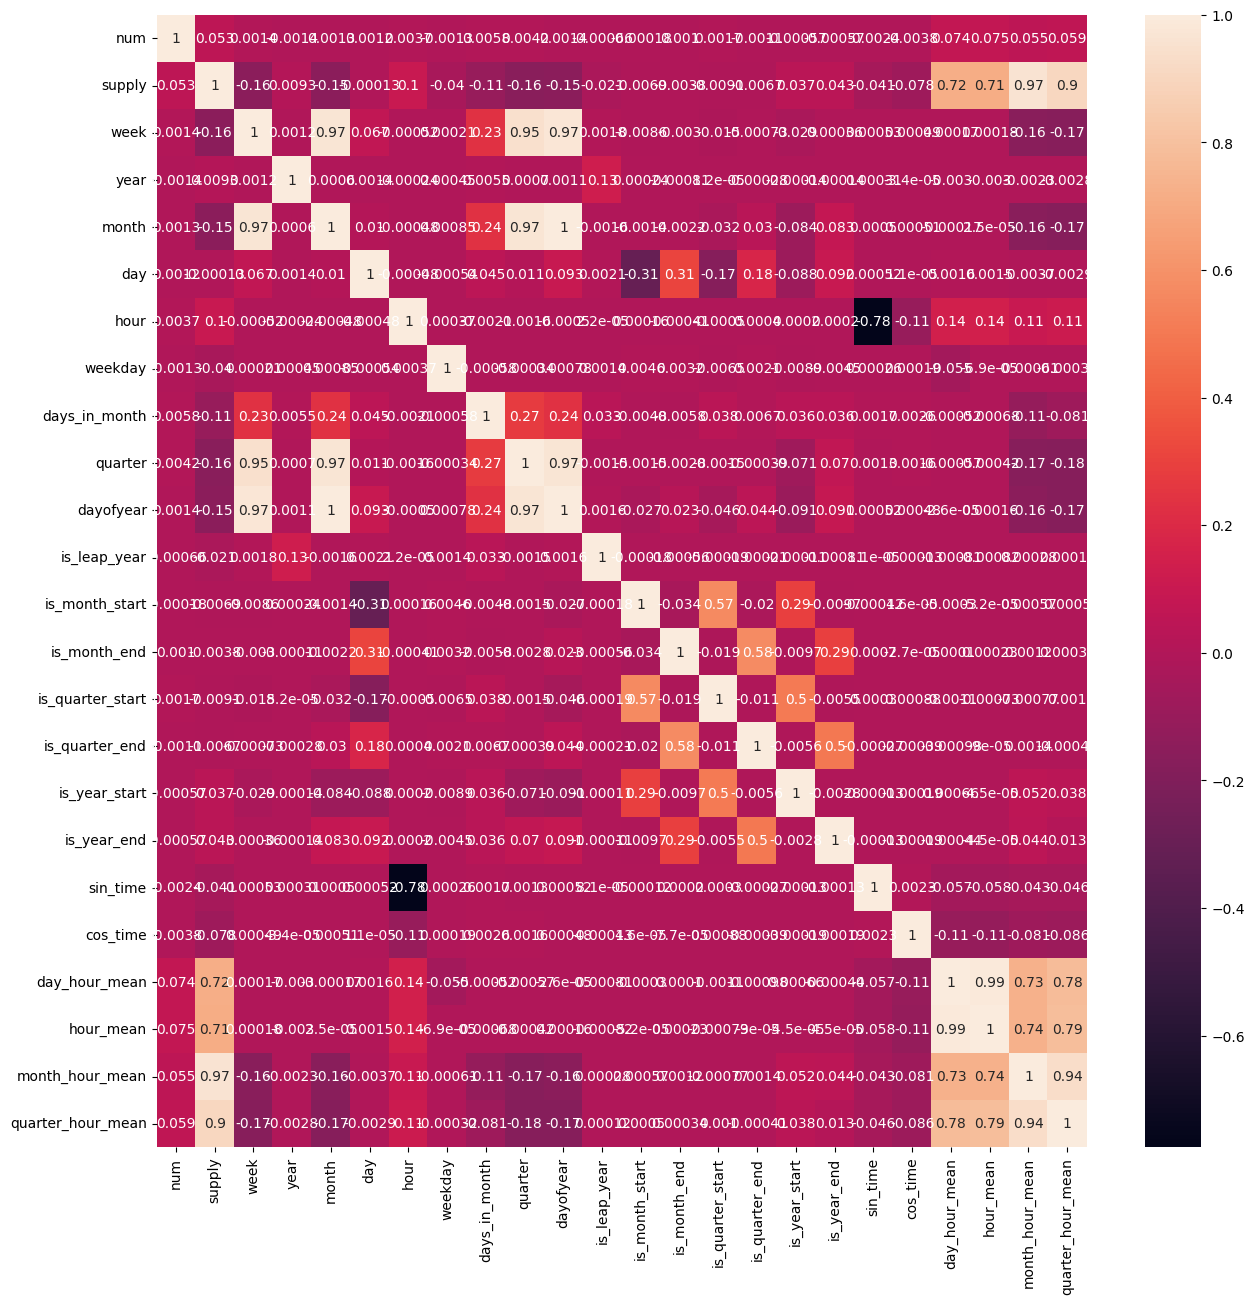

In [ ]:
#Heatmap을 통해 coefficient 확인 => feature selection
import seaborn as sn

feature = train.columns
train_co = train[feature]

train_co.corr()

plt.figure(figsize=(15,15))
sn.heatmap(train_co.corr(), annot=True)

사용 feature : month, hour, day_hour_mean, hour_mean, month_hour_mean, quarter_hour_mean  

구분 코드마다 데이터프레임으로 구분하여 각 구분 코드마다 학습

In [ ]:
for i in range(len(train['num'].unique())):
    globals()['total_{}'.format(i+1)] = train[train['num'] == i+1]
    features = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
    globals()['X_{}'.format(i+1)] = locals()['total_{}'.format(i+1)][features]
    globals()['y_{}'.format(i+1)] = locals()['total_{}'.format(i+1)]['supply']

    globals()['test_{}'.format(i+1)] = test[test['num'] == i+1]
    globals()['X_test_{}'.format(i+1)] = locals()['test_{}'.format(i+1)][features]

In [ ]:
!pip install optuna 
import optuna

In [ ]:
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Training

### num = 1

In [ ]:
def objective(trial,data=total_1):

    def NMAE(true, pred):
        return np.mean(abs(true - pred) / true)


    train_years = [0,1,2,3,4]
    val_years = [5]

    val = total_1[total_1['year'].isin(val_years)]
    train = total_1[total_1['year'].isin(train_years)]

    features = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
    # train_x = train[features]
    # train_y = train['supply']

    # val_x = val[features]
    # val_y = val['supply']

    train_x = train[features]
    train_y = np.log1p(train['supply'])

    val_x = val[features]
    val_y = np.log1p(val['supply'])

    param = {
        'metric': 'mse', 
         'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(val_x)
    
    nmae = mean_absolute_error(val_y, preds)
    
    return nmae

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-12-10 03:24:36,289] A new study created in memory with name: no-name-853783dc-4448-4440-8a04-f6066bf89926
[I 2021-12-10 03:24:37,744] Trial 0 finished with value: 0.1369457080294997 and parameters: {'reg_alpha': 2.0120586316202007, 'reg_lambda': 0.001059383140775921, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 158, 'min_child_samples': 226, 'min_data_per_groups': 17}. Best is trial 0 with value: 0.1369457080294997.
[I 2021-12-10 03:24:39,319] Trial 1 finished with value: 0.13771567613051897 and parameters: {'reg_alpha': 0.005602165218255232, 'reg_lambda': 0.001360525276693575, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 27, 'min_child_samples': 221, 'min_data_per_groups': 16}. Best is trial 0 with value: 0.1369457080294997.
[I 2021-12-10 03:24:41,863] Trial 2 finished with value: 0.136073932007482 and parameters: {'reg_alpha': 0.001234764078244128, 'reg_lambda': 0.0026528

Number of finished trials: 200
Best trial: {'reg_alpha': 0.005120894551653628, 'reg_lambda': 0.03389448379128691, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 599, 'min_child_samples': 1, 'min_data_per_groups': 41}


Best trial: {'reg_alpha': 1.6870111373345866, 'reg_lambda': 6.517050327807117, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 592, 'min_child_samples': 54, 'min_data_per_groups': 8}

In [ ]:
params=study.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mse'

In [ ]:
columns = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
preds_1 = np.zeros(test_1.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
nmae=[]  # list contains mae for each fold
n=0
for trn_idx, test_idx in kf.split(total_1[columns],total_1['supply']):
    X_tr,X_val=total_1[columns].iloc[trn_idx],total_1[columns].iloc[test_idx]
    y_tr,y_val=np.log1p(total_1['supply'].iloc[trn_idx]),np.log1p(total_1['supply'].iloc[test_idx])
    model = LGBMRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds_1+=np.expm1(model.predict(test_1[columns]))/kf.n_splits
    nmae.append(mean_absolute_error(y_val, model.predict(X_val)))
    print(n+1,nmae[n])
    n+=1

1 0.13004434583378505
2 0.12721933113735848
3 0.127609250064068
4 0.12840702340473828
5 0.12966142096909614


### num = 2

In [ ]:
def objective(trial,data=total_2):
    train_years = [0,1,2,3,4]
    val_years = [5]

    val = total_2[total_2['year'].isin(val_years)]
    train = total_2[total_2['year'].isin(train_years)]

    features = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
    # train_x = train[features]
    # train_y = train['supply']

    # val_x = val[features]
    # val_y = val['supply']

    train_x = train[features]
    train_y = np.log1p(train['supply'])

    val_x = val[features]
    val_y = np.log1p(val['supply'])

    param = {
        'metric': 'mse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(val_x)
    
    nmae = mean_absolute_error(val_y, preds)
    
    return nmae

In [ ]:
study_2 = optuna.create_study(direction='minimize')
study_2.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study_2.trials))
print('Best trial:', study_2.best_trial.params)

[I 2021-12-10 03:37:25,471] A new study created in memory with name: no-name-49dac200-e6a4-401c-aefc-894fda67ce48
[I 2021-12-10 03:37:34,490] Trial 0 finished with value: 0.15599429747154364 and parameters: {'reg_alpha': 0.13823518395083095, 'reg_lambda': 0.15703765113481347, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 369, 'min_child_samples': 248, 'min_data_per_groups': 60}. Best is trial 0 with value: 0.15599429747154364.
[I 2021-12-10 03:37:48,387] Trial 1 finished with value: 0.16107015353995516 and parameters: {'reg_alpha': 0.9293850120075269, 'reg_lambda': 0.3115978473497363, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 544, 'min_child_samples': 230, 'min_data_per_groups': 45}. Best is trial 0 with value: 0.15599429747154364.
[I 2021-12-10 03:37:58,359] Trial 2 finished with value: 0.15598050112421763 and parameters: {'reg_alpha': 0.004333592092486521, 'reg_lambda': 0.0263

Number of finished trials: 200
Best trial: {'reg_alpha': 0.008340435403748661, 'reg_lambda': 0.08411070776175017, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 129, 'min_child_samples': 18, 'min_data_per_groups': 40}


Best trial: {'reg_alpha': 0.13939826363370847, 'reg_lambda': 0.1298141223070523, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 387, 'min_child_samples': 207, 'min_data_per_groups': 11}

In [ ]:
params=study_2.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mse'

In [ ]:
columns = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
preds_2 = np.zeros(test_2.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
nmae=[]  # list contains mae for each fold
n=0
for trn_idx, test_idx in kf.split(total_2[columns],total_2['supply']):
    X_tr,X_val=total_2[columns].iloc[trn_idx],total_2[columns].iloc[test_idx]
    y_tr,y_val=np.log1p(total_2['supply'].iloc[trn_idx]),np.log1p(total_2['supply'].iloc[test_idx])
    model = LGBMRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds_2+=np.expm1(model.predict(test_2[columns]))/kf.n_splits
    nmae.append(mean_absolute_error(y_val, model.predict(X_val)))
    print(n+1,nmae[n])
    n+=1

1 0.14485167200699806
2 0.14594670947177893
3 0.14356943454859855
4 0.14477438612728544
5 0.14720386329124416


### num = 3

In [ ]:
def objective(trial,data=total_3):
    train_years = [0,1,2,3,4]
    val_years = [5]

    val = total_3[total_3['year'].isin(val_years)]
    train = total_3[total_3['year'].isin(train_years)]

    features = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
    # train_x = train[features]
    # train_y = train['supply']

    # val_x = val[features]
    # val_y = val['supply']

    train_x = train[features]
    train_y = np.log1p(train['supply'])

    val_x = val[features]
    val_y = np.log1p(val['supply'])

    param = {
        'metric': 'mse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(val_x)
    
    nmae = mean_absolute_error(val_y, preds)
    
    return nmae

In [ ]:
study_3 = optuna.create_study(direction='minimize')
study_3.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study_3.trials))
print('Best trial:', study_3.best_trial.params)

[I 2021-12-10 03:55:01,414] A new study created in memory with name: no-name-eedb5b9a-4708-4b0b-afe1-5e7d5a1f9fb3
[I 2021-12-10 03:55:02,993] Trial 0 finished with value: 0.48255985349109815 and parameters: {'reg_alpha': 1.9840288394911785, 'reg_lambda': 7.239853407810815, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 55, 'min_child_samples': 97, 'min_data_per_groups': 78}. Best is trial 0 with value: 0.48255985349109815.
[I 2021-12-10 03:55:04,629] Trial 1 finished with value: 0.48409261669834985 and parameters: {'reg_alpha': 0.045618977429324914, 'reg_lambda': 0.0012512589341907442, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 206, 'min_child_samples': 125, 'min_data_per_groups': 83}. Best is trial 0 with value: 0.48255985349109815.
[I 2021-12-10 03:55:06,482] Trial 2 finished with value: 0.4851812460560734 and parameters: {'reg_alpha': 0.0012275372638957506, 'reg_lambda': 1.56835

Number of finished trials: 200
Best trial: {'reg_alpha': 0.1581934072036625, 'reg_lambda': 0.1283423995291508, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 2, 'min_child_samples': 274, 'min_data_per_groups': 85}


Best trial: {'reg_alpha': 3.2276649718096393, 'reg_lambda': 1.8214877565484855, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_samples': 20, 'min_data_per_groups': 11}

In [ ]:
params=study_3.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mse'

In [ ]:
columns = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
preds_3 = np.zeros(test_3.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
mae=[]  # list contains mae for each fold
n=0
for trn_idx, test_idx in kf.split(total_3[columns],total_3['supply']):
    X_tr,X_val=total_3[columns].iloc[trn_idx],total_3[columns].iloc[test_idx]
    y_tr,y_val=np.log1p(total_3['supply'].iloc[trn_idx]),np.log1p(total_3['supply'].iloc[test_idx])
    model = LGBMRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds_3+=np.expm1(model.predict(test_3[columns]))/kf.n_splits
    mae.append(mean_absolute_error(y_val, model.predict(X_val)))
    print(n+1,mae[n])
    n+=1

1 0.33070572600301856
2 0.3212069131445696
3 0.3336240156957598
4 0.3200750732618112
5 0.31810921398837955


num = 4

In [ ]:
def objective(trial,data=total_4):
    train_years = [0,1,2,3,4]
    val_years = [5]

    val = total_4[total_4['year'].isin(val_years)]
    train = total_4[total_4['year'].isin(train_years)]

    features = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
    # train_x = train[features]
    # train_y = train['supply']

    # val_x = val[features]
    # val_y = val['supply']

    train_x = train[features]
    train_y = np.log1p(train['supply'])

    val_x = val[features]
    val_y = np.log1p(val['supply'])

    param = {
        'metric': 'mse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(val_x)
    
    nmae = mean_absolute_error(val_y, preds)
    
    return nmae

In [ ]:
study_4 = optuna.create_study(direction='minimize')
study_4.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study_4.trials))
print('Best trial:', study_4.best_trial.params)

[I 2021-12-10 03:59:38,345] A new study created in memory with name: no-name-922d899d-a9dc-4da9-85cd-a06f27648c56
[I 2021-12-10 03:59:44,055] Trial 0 finished with value: 0.1537031407536909 and parameters: {'reg_alpha': 1.6057272489113037, 'reg_lambda': 0.03408915005941619, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 687, 'min_child_samples': 144, 'min_data_per_groups': 27}. Best is trial 0 with value: 0.1537031407536909.
[I 2021-12-10 04:00:07,455] Trial 1 finished with value: 0.1538284152603314 and parameters: {'reg_alpha': 0.0037361933464643156, 'reg_lambda': 0.08644976285769207, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 678, 'min_child_samples': 281, 'min_data_per_groups': 81}. Best is trial 0 with value: 0.1537031407536909.
[I 2021-12-10 04:00:09,807] Trial 2 finished with value: 0.15501036641345742 and parameters: {'reg_alpha': 6.36669697975562, 'reg_lambda': 0.35969244571

Number of finished trials: 200
Best trial: {'reg_alpha': 0.07319340850027085, 'reg_lambda': 1.545628807227905, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 562, 'min_child_samples': 165, 'min_data_per_groups': 62}


In [ ]:
params=study_4.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mse'

In [ ]:
columns = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
preds_4 = np.zeros(test_4.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
nmae=[]  # list contains mae for each fold
n=0
for trn_idx, test_idx in kf.split(total_4[columns],total_4['supply']):
    X_tr,X_val=total_4[columns].iloc[trn_idx],total_4[columns].iloc[test_idx]
    y_tr,y_val=np.log1p(total_4['supply'].iloc[trn_idx]),np.log1p(total_4['supply'].iloc[test_idx])
    model = LGBMRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds_4+=np.expm1(model.predict(test_4[columns]))/kf.n_splits
    nmae.append(mean_absolute_error(y_val, model.predict(X_val)))
    print(n+1,nmae[n])
    n+=1

1 0.1346917876327665
2 0.1350356411185148
3 0.13478379097221774
4 0.13585719374967753
5 0.1367069779962312


### num = 5

In [ ]:
def objective(trial,data=total_5):
    train_years = [0,1,2,3,4]
    val_years = [5]

    val = total_5[total_5['year'].isin(val_years)]
    train = total_5[total_5['year'].isin(train_years)]

    features = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
    # train_x = train[features]
    # train_y = train['supply']

    # val_x = val[features]
    # val_y = val['supply']

    train_x = train[features]
    train_y = np.log1p(train['supply'])

    val_x = val[features]
    val_y = np.log1p(val['supply'])

    param = {
        'metric': 'mse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(val_x)
    
    nmae = mean_absolute_error(val_y, preds)
    
    return nmae

In [ ]:
study_5 = optuna.create_study(direction='minimize')
study_5.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study_5.trials))
print('Best trial:', study_5.best_trial.params)

[I 2021-12-10 04:41:25,226] A new study created in memory with name: no-name-b40f33ae-05fd-4675-ae4a-9b74940dab5b
[I 2021-12-10 04:41:27,971] Trial 0 finished with value: 0.16926129145423152 and parameters: {'reg_alpha': 0.023442585270617138, 'reg_lambda': 0.04507358485105531, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 324, 'min_child_samples': 37, 'min_data_per_groups': 3}. Best is trial 0 with value: 0.16926129145423152.
[I 2021-12-10 04:41:31,067] Trial 1 finished with value: 0.1695702338292304 and parameters: {'reg_alpha': 0.003444637616313111, 'reg_lambda': 0.0015784643637386173, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 364, 'min_child_samples': 48, 'min_data_per_groups': 98}. Best is trial 0 with value: 0.16926129145423152.
[I 2021-12-10 04:41:32,761] Trial 2 finished with value: 0.16973045632867362 and parameters: {'reg_alpha': 0.004803157231774449, 'reg_lambda': 4.15

Number of finished trials: 200
Best trial: {'reg_alpha': 0.04799153448582614, 'reg_lambda': 0.008720450306767491, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 435, 'min_child_samples': 21, 'min_data_per_groups': 94}


In [ ]:
params=study_5.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mse'

In [ ]:
columns = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
preds_5 = np.zeros(test_5.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
nmae=[]  # list contains mae for each fold
n=0
for trn_idx, test_idx in kf.split(total_5[columns],total_5['supply']):
    X_tr,X_val=total_5[columns].iloc[trn_idx],total_5[columns].iloc[test_idx]
    y_tr,y_val=np.log1p(total_5['supply'].iloc[trn_idx]),np.log1p(total_5['supply'].iloc[test_idx])
    model = LGBMRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds_5+=np.expm1(model.predict(test_5[columns]))/kf.n_splits
    nmae.append(mean_absolute_error(y_val, model.predict(X_val)))
    print(n+1,nmae[n])
    n+=1

1 0.14010082094730103
2 0.139873296980151
3 0.14273758402450454
4 0.14081686419555708
5 0.1412861181323289


### num = 6

In [ ]:
def objective(trial,data=total_6):
    train_years = [0,1,2,3,4]
    val_years = [5]

    val = total_6[total_6['year'].isin(val_years)]
    train = total_6[total_6['year'].isin(train_years)]

    features = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
    # train_x = train[features]
    # train_y = train['supply']

    # val_x = val[features]
    # val_y = val['supply']

    train_x = train[features]
    train_y = np.log1p(train['supply'])

    val_x = val[features]
    val_y = np.log1p(val['supply'])
    
    param = {
        'metric': 'mse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(val_x)
    
    nmae = mean_absolute_error(val_y, preds)
    
    return nmae

In [ ]:
study_6 = optuna.create_study(direction='minimize')
study_6.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study_6.trials))
print('Best trial:', study_6.best_trial.params)

[I 2021-12-10 04:51:29,521] A new study created in memory with name: no-name-abc05d89-70ef-4b08-964a-c880c77f43ff
[I 2021-12-10 04:51:30,936] Trial 0 finished with value: 0.1578952885336382 and parameters: {'reg_alpha': 0.46729644302981593, 'reg_lambda': 2.5197203537279083, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 186, 'min_child_samples': 241, 'min_data_per_groups': 48}. Best is trial 0 with value: 0.1578952885336382.
[I 2021-12-10 04:51:32,035] Trial 1 finished with value: 0.1590324281901117 and parameters: {'reg_alpha': 0.09775363246977117, 'reg_lambda': 0.30237574227063163, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 539, 'min_child_samples': 210, 'min_data_per_groups': 98}. Best is trial 0 with value: 0.1578952885336382.
[I 2021-12-10 04:51:35,951] Trial 2 finished with value: 0.1587154891989369 and parameters: {'reg_alpha': 0.01917171198390965, 'reg_lambda': 0.001777404

Number of finished trials: 200
Best trial: {'reg_alpha': 0.001200137531579638, 'reg_lambda': 5.047935917187444, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 929, 'min_child_samples': 14, 'min_data_per_groups': 16}


In [ ]:
params=study_6.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mse'

In [ ]:
columns = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
preds_6 = np.zeros(test_6.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
nmae=[]  # list contains mae for each fold
n=0
for trn_idx, test_idx in kf.split(total_6[columns],total_6['supply']):
    X_tr,X_val=total_6[columns].iloc[trn_idx],total_6[columns].iloc[test_idx]
    y_tr,y_val=np.log1p(total_6['supply'].iloc[trn_idx]),np.log1p(total_6['supply'].iloc[test_idx])
    model = LGBMRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds_6+=np.expm1(model.predict(test_6[columns]))/kf.n_splits
    nmae.append(mean_absolute_error(y_val, model.predict(X_val)))
    print(n+1,nmae[n])
    n+=1

1 0.11499087112866908
2 0.11449526854987685
3 0.11693312718881141
4 0.11593160902432557
5 0.1159762527068083


### num = 7

In [ ]:
def objective(trial,data=total_7):
    train_years = [0,1,2,3,4]
    val_years = [5]

    val = total_7[total_7['year'].isin(val_years)]
    train = total_7[total_7['year'].isin(train_years)]

    features = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
    # train_x = train[features]
    # train_y = train['supply']

    # val_x = val[features]
    # val_y = val['supply']

    train_x = train[features]
    train_y = np.log1p(train['supply'])

    val_x = val[features]
    val_y = np.log1p(val['supply'])

    param = {
        'metric': 'mse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(val_x)
    
    nmae = mean_absolute_error(val_y, preds)
    
    return nmae

In [ ]:
study_7 = optuna.create_study(direction='minimize')
study_7.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study_7.trials))
print('Best trial:', study_7.best_trial.params)

[I 2021-12-10 05:04:57,720] A new study created in memory with name: no-name-97c75952-7d98-44ca-a0e0-dd1b2f6a4c57
[I 2021-12-10 05:05:01,322] Trial 0 finished with value: 0.14493278356966996 and parameters: {'reg_alpha': 2.2823174468771135, 'reg_lambda': 0.024659083220689625, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 223, 'min_child_samples': 46, 'min_data_per_groups': 79}. Best is trial 0 with value: 0.14493278356966996.
[I 2021-12-10 05:05:05,190] Trial 1 finished with value: 0.14509265925916526 and parameters: {'reg_alpha': 0.01784547203080137, 'reg_lambda': 0.013423813406061684, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 628, 'min_child_samples': 290, 'min_data_per_groups': 21}. Best is trial 0 with value: 0.14493278356966996.
[I 2021-12-10 05:05:08,420] Trial 2 finished with value: 0.14533061837789432 and parameters: {'reg_alpha': 3.5207038927252263, 'reg_lambda': 0.03863

Number of finished trials: 200
Best trial: {'reg_alpha': 0.0014495503362818277, 'reg_lambda': 0.014267335279447672, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 617, 'min_child_samples': 2, 'min_data_per_groups': 40}


In [ ]:
params=study_7.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mse'

In [ ]:
columns = ['month', 'hour', 'day_hour_mean', 'hour_mean', 'month_hour_mean', 'quarter_hour_mean']
preds_7 = np.zeros(test_7.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
nmae=[]  # list contains mae for each fold
n=0
for trn_idx, test_idx in kf.split(total_7[columns],total_7['supply']):
    X_tr,X_val=total_7[columns].iloc[trn_idx],total_7[columns].iloc[test_idx]
    y_tr,y_val=np.log1p(total_7['supply'].iloc[trn_idx]),np.log1p(total_7['supply'].iloc[test_idx])
    model = LGBMRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds_7+=np.expm1(model.predict(test_7[columns]))/kf.n_splits
    nmae.append(mean_absolute_error(y_val, model.predict(X_val)))
    print(n+1,nmae[n])
    n+=1

1 0.13456439494646596
2 0.13308872292070334
3 0.13627087469556265
4 0.1351915428965356
5 0.13538060262409266


## Test

In [ ]:
prediction = pd.DataFrame()
for i in range(len(train['num'].unique())):
    locals()['test_{}'.format(i+1)]['supply'] = 0
    locals()['test_{}'.format(i+1)]['supply'] = locals()['preds_{}'.format(i+1)]
    prediction = pd.concat([prediction, locals()['test_{}'.format(i+1)][['num', 'date', 'supply']]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
submission['공급량'] = prediction['supply']

In [ ]:
submission.to_csv(path + 'lgbm_optuna_best_outlier_blend.csv', index=False)

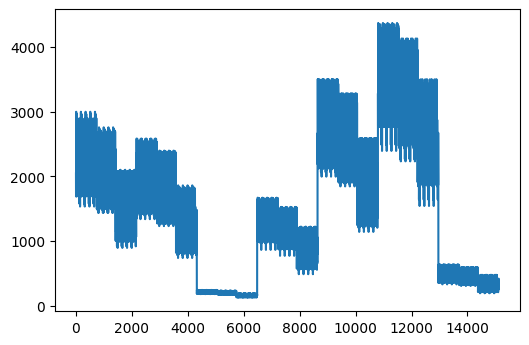

In [ ]:
submission['공급량'].plot()